In [1]:
import paho.mqtt.client as paho
import paho.mqtt.publish as publish
import time
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import os
from dotenv import load_dotenv
import json 
import math
import matplotlib.pyplot as plt

In [2]:
# --- Carrega as variáveis do arquivo .env ---
dotenv_path = 'Variables.env'

if not os.path.exists(dotenv_path):
    print(f"ERRO CRÍTICO: O arquivo .env '{dotenv_path}' não foi encontrado no diretório atual.")
    print("Certifique-se de que o arquivo 'Variables.env' está no mesmo diretório do seu script/notebook.")
    exit()
else:
    print(f"Arquivo .env '{dotenv_path}' encontrado. Carregando variáveis...")

load_dotenv(dotenv_path)

# --- Variáveis MQTT (do .env e tópicos adicionais) ---
MQTT_USERNAME = os.getenv("MQTT_USERNAME")
MQTT_PASSWORD = os.getenv("MQTT_PASSWORD")
MQTT_URL = os.getenv("MQTT_URL")
# IMPORTANTE: A porta 8883 é geralmente para TLS/SSL. Se você está usando Mosquitto local SEM TLS,
# a porta padrão é 1883. No seu último debug, estava 1883, então estou ajustando.
MQTT_PORT = int(os.getenv("MQTT_PORT", 1883)) # Usando 1883 como default se não especificado

# Tópicos para comunicação com o Front-end
MQTT_TOPIC_POSICAO = 'elevador/PosicaoAtual'
MQTT_TOPIC_VELOCIDADE = 'elevador/VelocidadeAtual'
MQTT_TOPIC_POTENCIA = 'elevador/PotenciaMotor'
MQTT_TOPIC_COMANDO_ANDAR = 'elevador/ComandoAndar'

# --- DEBUG: Imprimir os valores lidos para verificar se estão corretos ---
print(f"DEBUG - MQTT_USERNAME lido: '{MQTT_USERNAME}'")
print(f"DEBUG - MQTT_PASSWORD lido: '{MQTT_PASSWORD}'")
print(f"DEBUG - MQTT_URL lido: '{MQTT_URL}'")
print(f"DEBUG - MQTT_PORT lido: {MQTT_PORT}")

Arquivo .env 'Variables.env' encontrado. Carregando variáveis...
DEBUG - MQTT_USERNAME lido: ''
DEBUG - MQTT_PASSWORD lido: ''
DEBUG - MQTT_URL lido: 'localhost'
DEBUG - MQTT_PORT lido: 1883


In [3]:
# --- Parâmetros da Simulação e Elevador ---
DT = 0.2  # Intervalo de tempo da simulação (s)

# Andares físicos que o elevador irá considerar para esta simulação (somente hóspedes)
NUM_ANDAR_MIN_SIMULACAO = 0  # Térreo
NUM_ANDAR_MAX_SIMULACAO = 8  # 8º Andar

# Mapeamento explícito de cada andar para sua altura em metros (APENAS os andares para hóspedes)
FLOOR_HEIGHT_MAP = {
    0: 0.0,    # Térreo
    1: 4.0,    # 1º Andar
    2: 7.0,    # 2º Andar
    3: 10.0,   # 3º Andar
    4: 13.0,   # 4º Andar
    5: 16.0,   # 5º Andar
    6: 19.0,   # 6º Andar
    7: 22.0,   # 7º Andar
    8: 25.0    # 8º Andar
}

# Altura Mínima e Máxima do elevador para ESTA SIMULAÇÃO (apenas andares de hóspedes)
ALTURA_MIN_GERAL = min(FLOOR_HEIGHT_MAP.values()) # 0.0
ALTURA_MAX_GERAL = max(FLOOR_HEIGHT_MAP.values()) # 25.0

# Lista dos andares acessíveis (neste novo escopo, são todos os considerados)
ANDARES_ACESSIVEIS = set(FLOOR_HEIGHT_MAP.keys()) # {0, 1, 2, 3, 4, 5, 6, 7, 8}

# Certifique-se de que andar_alvo_global esteja visível para todas as funções
andar_alvo_global = 0 # Inicia no Térreo (Andar 0)

In [4]:
def get_approx_floor(posicao_m):
    if posicao_m <= 0.0:
        return 0 # Térreo

    closest_floor = 0
    min_difference = float('inf')

    # Itera sobre o dicionário global FLOOR_HEIGHT_MAP
    for floor_num, floor_height in FLOOR_HEIGHT_MAP.items():
        difference = abs(posicao_m - floor_height)
        if difference < min_difference:
            min_difference = difference
            closest_floor = floor_num

    return max(0, min(8, closest_floor))

In [5]:
amplitude_total_movimento_cm = (ALTURA_MAX_GERAL - ALTURA_MIN_GERAL) * 100 
VELOCIDADE_MAX_ELEVADOR_CM_S = 100 
margem_delta_erro_universo = VELOCIDADE_MAX_ELEVADOR_CM_S * 0.5 


TOLERANCIA_PEQUENO_CM = 10 


erro = ctrl.Antecedent(np.arange(-amplitude_total_movimento_cm - 200, amplitude_total_movimento_cm + 200 + 1, 1), 'erro')
erro['muito_negativo'] = fuzz.trimf(erro.universe, [-amplitude_total_movimento_cm - 100, -amplitude_total_movimento_cm - 100, -amplitude_total_movimento_cm / 2])
erro['negativo'] = fuzz.trimf(erro.universe, [-amplitude_total_movimento_cm / 2, -TOLERANCIA_PEQUENO_CM * 3, -TOLERANCIA_PEQUENO_CM])
erro['pequeno'] = fuzz.trimf(erro.universe, [-TOLERANCIA_PEQUENO_CM, 0, TOLERANCIA_PEQUENO_CM]) 
erro['positivo'] = fuzz.trimf(erro.universe, [TOLERANCIA_PEQUENO_CM, TOLERANCIA_PEQUENO_CM * 3, amplitude_total_movimento_cm / 2])
erro['muito_positivo'] = fuzz.trimf(erro.universe, [amplitude_total_movimento_cm / 2, amplitude_total_movimento_cm + 100, amplitude_total_movimento_cm + 100])


delta_erro = ctrl.Antecedent(np.arange(-VELOCIDADE_MAX_ELEVADOR_CM_S - margem_delta_erro_universo, VELOCIDADE_MAX_ELEVADOR_CM_S + margem_delta_erro_universo + 1, 1), 'delta_erro')
delta_erro['diminuindo_rapido'] = fuzz.trimf(delta_erro.universe, [-150, -150, -75])
delta_erro['diminuindo'] = fuzz.trimf(delta_erro.universe, [-100, -40, 0])
delta_erro['estavel'] = fuzz.trimf(delta_erro.universe, [-15, 0, 15]) 
delta_erro['aumentando'] = fuzz.trimf(delta_erro.universe, [0, 40, 100])
delta_erro['aumentando_rapido'] = fuzz.trimf(delta_erro.universe, [75, 150, 150])


# --- Definição da Variável de Saída (Consequent) ---
potencia_motor = ctrl.Consequent(np.arange(0, 101, 1), 'potencia_motor')
# Manter 'zero' bem estreito, talvez até mais um pouco, dependendo dos testes.
potencia_motor['frenagem_maxima'] = fuzz.trimf(potencia_motor.universe, [0, 0, 20])
potencia_motor['frenagem_media'] = fuzz.trimf(potencia_motor.universe, [10, 30, 50])
potencia_motor['zero'] = fuzz.trimf(potencia_motor.universe, [49, 50, 51]) 
potencia_motor['aceleracao_media'] = fuzz.trimf(potencia_motor.universe, [50, 70, 90])
potencia_motor['aceleracao_maxima'] = fuzz.trimf(potencia_motor.universe, [80, 100, 100])


Plotando as funções de pertinência das variáveis fuzzy...


C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


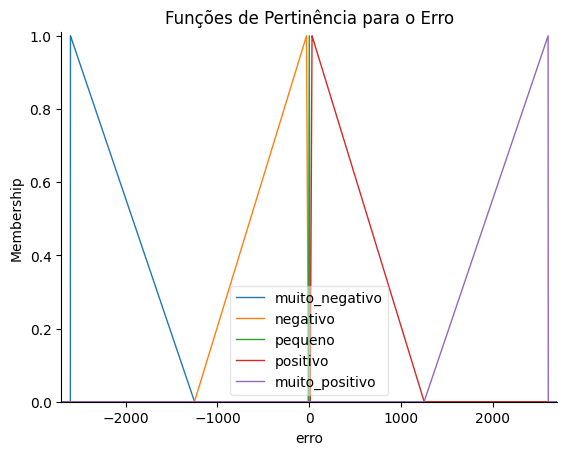

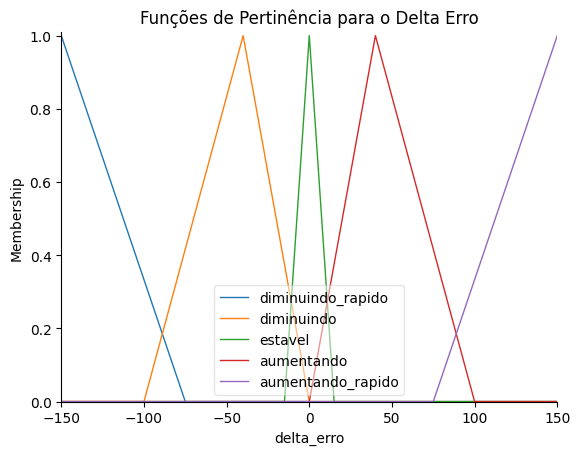

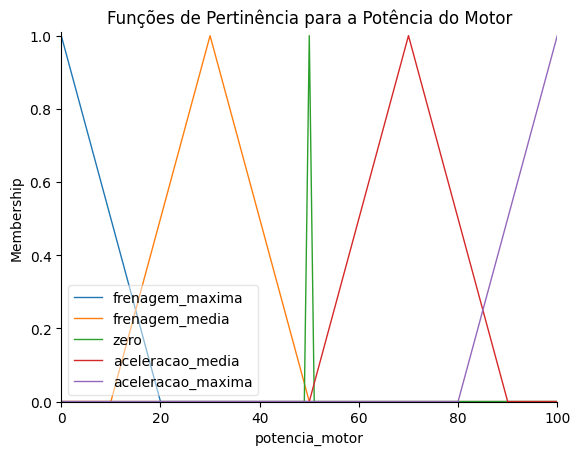

In [6]:
print("Plotando as funções de pertinência das variáveis fuzzy...")

# Plotar as funções de pertinência para 'erro'
erro.view()
plt.title('Funções de Pertinência para o Erro')

# Plotar as funções de pertinência para 'delta_erro'
delta_erro.view()
plt.title('Funções de Pertinência para o Delta Erro')

# Plotar as funções de pertinência para 'potencia_motor'
potencia_motor.view()
plt.title('Funções de Pertinência para a Potência do Motor')

plt.show() # Exibe todos os gráficos gerados pelas chamadas .view()

In [7]:
# Regras para quando o Erro é MUITO NEGATIVO (Elevador muito ACIMA do alvo, precisa descer muito)
rule1 = ctrl.Rule(erro['muito_negativo'] & delta_erro['diminuindo_rapido'], potencia_motor['frenagem_maxima'])
rule2 = ctrl.Rule(erro['muito_negativo'] & delta_erro['diminuindo'], potencia_motor['frenagem_maxima'])
rule3 = ctrl.Rule(erro['muito_negativo'] & delta_erro['estavel'], potencia_motor['frenagem_media'])
rule4 = ctrl.Rule(erro['muito_negativo'] & delta_erro['aumentando'], potencia_motor['frenagem_media'])
rule5 = ctrl.Rule(erro['muito_negativo'] & delta_erro['aumentando_rapido'], potencia_motor['frenagem_media'])

# Regras para quando o Erro é NEGATIVO (Elevador ACIMA do alvo, precisa descer)
rule6 = ctrl.Rule(erro['negativo'] & delta_erro['diminuindo_rapido'], potencia_motor['frenagem_maxima'])
rule7 = ctrl.Rule(erro['negativo'] & delta_erro['diminuindo'], potencia_motor['frenagem_media'])
rule8 = ctrl.Rule(erro['negativo'] & delta_erro['estavel'], potencia_motor['frenagem_media'])
rule9 = ctrl.Rule(erro['negativo'] & delta_erro['aumentando'], potencia_motor['zero'])
rule10 = ctrl.Rule(erro['negativo'] & delta_erro['aumentando_rapido'], potencia_motor['frenagem_media']) # AJUSTADA: Mantém potência de freio para descer mais rápido

# Regras para quando o Erro é PEQUENO (Elevador perto do alvo, fase de ajuste/parada)
rule11 = ctrl.Rule(erro['pequeno'] & delta_erro['diminuindo_rapido'], potencia_motor['frenagem_media'])
rule12 = ctrl.Rule(erro['pequeno'] & delta_erro['diminuindo'], potencia_motor['zero'])
rule13 = ctrl.Rule(erro['pequeno'] & delta_erro['estavel'], potencia_motor['zero'])
rule14 = ctrl.Rule(erro['pequeno'] & delta_erro['aumentando'], potencia_motor['zero'])
# CORREÇÃO CRÍTICA NA RULE 15: Se o erro é pequeno, mas a velocidade está aumentando muito rápido (subindo),
# o elevador vai passar do alvo. Ação deve ser de FRENAGEM, não aceleração.
rule15 = ctrl.Rule(erro['pequeno'] & delta_erro['aumentando_rapido'], potencia_motor['frenagem_media'])

# Regras para quando o Erro é POSITIVO (Elevador ABAIXO do alvo, precisa subir)
# CRÍTICO: rule16 estava freando o elevador enquanto ele subia para o alvo
rule16 = ctrl.Rule(erro['positivo'] & delta_erro['diminuindo_rapido'], potencia_motor['zero']) # AJUSTADA: Permite que o elevador desacelere naturalmente ou mantenha velocidade sem tranco reverso.
# SUGESTÃO DE CORREÇÃO NA RULE 17: Se o erro é positivo (precisa subir) e está diminuindo (descendo ou parando de subir),
# a ação deve ser de ACELERAR para cima, não frear para baixo.
rule17 = ctrl.Rule(erro['positivo'] & delta_erro['diminuindo'], potencia_motor['aceleracao_media']) # ALTERADA: Acelerar para cima se estiver descendo ou parando de subir
rule18 = ctrl.Rule(erro['positivo'] & delta_erro['estavel'], potencia_motor['aceleracao_media'])
rule19 = ctrl.Rule(erro['positivo'] & delta_erro['aumentando'], potencia_motor['aceleracao_maxima'])
rule20 = ctrl.Rule(erro['positivo'] & delta_erro['aumentando_rapido'], potencia_motor['aceleracao_maxima'])

# Regras para quando o Erro é MUITO POSITIVO (Elevador muito ABAIXO do alvo, precisa subir muito)
# CRÍTICO: rule21 estava dando zero potência quando precisava acelerar para subir
rule21 = ctrl.Rule(erro['muito_positivo'] & delta_erro['diminuindo_rapido'], potencia_motor['aceleracao_maxima']) # AJUSTADA: Garante que o elevador mantenha aceleração se estiver subindo rápido para o alvo distante.
rule22 = ctrl.Rule(erro['muito_positivo'] & delta_erro['diminuindo'], potencia_motor['aceleracao_media'])
rule23 = ctrl.Rule(erro['muito_positivo'] & delta_erro['estavel'], potencia_motor['aceleracao_maxima'])
rule24 = ctrl.Rule(erro['muito_positivo'] & delta_erro['aumentando'], potencia_motor['aceleracao_maxima'])
rule25 = ctrl.Rule(erro['muito_positivo'] & delta_erro['aumentando_rapido'], potencia_motor['aceleracao_maxima'])


In [8]:
# Construir o sistema de controle
sistema_controle = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5,
    rule6, rule7, rule8, rule9, rule10,
    rule11, rule12, rule13, rule14, rule15,
    rule16, rule17, rule18, rule19, rule20,
    rule21, rule22, rule23, rule24, rule25
])
simulador_fuzzy = ctrl.ControlSystemSimulation(sistema_controle)

In [9]:
class ElevadorRecorrencia:
    def __init__(self, posicao_inicial=0.0):
        self.posicao = posicao_inicial
        self.velocidade = 0.0
        self.aceleracao = 0.0
        self.potencia_motor = 0.0
        self.andar_alvo = 0
        self.posicao_alvo_m = 0.0
        self.erro_anterior = 0.0
        
        # NOVO: Flag para controlar se o elevador está "habilitado" a se mover (não em emergência)
        self.movimento_habilitado = True 

        # NOVO: Atributo para armazenar a direção atual (inicializa como parado)
        self.direcao = "parado" 

        # Estas variáveis agora serão mantidas pelo objeto para fácil acesso no loop principal
        self.andar_atual_aprox = get_approx_floor(posicao_inicial) # Inicializa o andar aproximado
        self.erro_cm = 0.0 # Inicializa o erro
        self.delta_erro_cm_s = 0.0 # Inicializa o delta_erro

        self.andar_alvo = andar_alvo_global # Usa a variável global
        self.posicao_alvo_m = self._calcular_altura_andar(self.andar_alvo)

        self.posicao_anterior_para_velocidade_calc = posicao_inicial

    def _calcular_altura_andar(self, andar):
        """Calcula a altura em metros para um dado número de andar usando o mapa."""
        return FLOOR_HEIGHT_MAP.get(andar, 0.0)

    def definir_andar_alvo(self, novo_andar_alvo):
        """Define o novo andar alvo e atualiza a posição alvo em metros."""
        # NOVO: Apenas permite definir um novo alvo se o movimento estiver habilitado
        if self.movimento_habilitado:
            self.andar_alvo = novo_andar_alvo
            self.posicao_alvo_m = self._calcular_altura_andar(self.andar_alvo)
            print(f"Alvo definido para o Andar {self.andar_alvo} ({self.posicao_alvo_m:.4f} m).")
        else:
            print(f"Alvo para o Andar {novo_andar_alvo} ignorado: Movimento desabilitado (emergência).")


    # NOVO: Métodos para parar e permitir o movimento em caso de emergência
    def parar_movimento(self):
        """Para o elevador imediatamente, definindo velocidade e aceleracao para zero
        e desabilitando o movimento."""
        self.velocidade = 0.0
        self.aceleracao = 0.0
        self.potencia_motor = 0.0 # Garante que não há força aplicada
        self.movimento_habilitado = False
        self.direcao = "parado" # Define a direção como parado imediatamente ao parar
        print("Elevador PARADO por EMERGÊNCIA.")

    def permitir_movimento(self):
        """Permite que o elevador retome o movimento."""
        self.movimento_habilitado = True
        # A direção será atualizada na próxima chamada a atualizar_estado
        print("Elevador HABILITADO para movimento (emergência desativada).")

    # NOVO: Métodos para obter os valores para publicação no MQTT
    def obter_andar_aprox(self):
        return self.andar_atual_aprox

    def obter_posicao_m(self):
        return self.posicao

    def obter_erro_cm(self):
        return self.erro_cm
    
    def obter_velocidade_ms(self):
        return self.velocidade
    
    def obter_potencia_motor_perc(self):
        return self.potencia_motor

    def obter_direcao(self): # NOVO MÉTODO PARA OBTER A DIREÇÃO
        return self.direcao


    def atualizar_estado(self, dt):
        """
        Atualiza o estado do elevador usando o sistema fuzzy e o Modelo de Recursão Discreta (Equação 1).
        """
        # NOVO: Só executa a lógica de atualização se o movimento estiver habilitado
        if not self.movimento_habilitado:
            # Se o movimento não está habilitado, retorna os valores atuais sem alterá-los
            # para que o loop principal possa publicar o estado parado.
            # A direção já está definida como "parado" em parar_movimento
            return self.posicao, self.velocidade, self.potencia_motor, self.erro_cm, self.delta_erro_cm_s


        # 1. Calcular Erro e Delta Erro para o Sistema Fuzzy
        erro_atual = (self.posicao_alvo_m - self.posicao) * 100
        delta_erro = (erro_atual - self.erro_anterior) / dt
        self.erro_anterior = erro_atual

        # 2. Passar os valores para o simulador fuzzy e obter a potência de saída
        simulador_fuzzy.input['erro'] = erro_atual
        simulador_fuzzy.input['delta_erro'] = delta_erro

        try:
            simulador_fuzzy.compute()
            self.potencia_motor = simulador_fuzzy.output['potencia_motor']
        except ValueError as e:
            print(f"Erro no cálculo fuzzy: {e}. Erro: {erro_atual}, Delta Erro: {delta_erro}")
            self.potencia_motor = 0 # Define uma potência padrão em caso de erro para evitar NaN

        # --- 3. APLICAÇÃO DO MODELO FÍSICO DA EQUAÇÃO 1 DO PDF ---
        
        potencia_real_aplicada_percent = self.potencia_motor * 0.9 
        potencia_direcional_normalizada = (potencia_real_aplicada_percent - 45) / 45.0

        # Constantes da Equação 1 do PDF
        k1 = 1
        k2 = 0.251287

        posicao_anterior_para_velocidade = self.posicao

        self.posicao = k1 * self.posicao * 0.999 + potencia_direcional_normalizada * k2

        # 4. Inferir a velocidade a partir da mudança na posição (Equação 2)
        if dt > 0:
            self.velocidade = (self.posicao - posicao_anterior_para_velocidade) / dt
        else:
            self.velocidade = 0.0

        # 5. Aplicar limites físicos de posição e velocidade
        if self.posicao < ALTURA_MIN_GERAL:
            self.posicao = ALTURA_MIN_GERAL
            self.velocidade = 0.0
        if self.posicao > ALTURA_MAX_GERAL:
            self.posicao = ALTURA_MAX_GERAL
            self.velocidade = 0.0

        VELOCIDADE_MAX_DO_ELEVADOR = 1.0 # m/s (Conforme Tabela 1)
        if self.velocidade > VELOCIDADE_MAX_DO_ELEVADOR:
            self.velocidade = VELOCIDADE_MAX_DO_ELEVADOR
        elif self.velocidade < -VELOCIDADE_MAX_DO_ELEVADOR:
            self.velocidade = -VELOCIDADE_MAX_DO_ELEVADOR
            
        # 6. Condição de parada / Ajuste fino:
        # Se estiver muito perto do alvo e quase parado, "trava" no alvo
        if abs(self.posicao_alvo_m - self.posicao) < 0.02 and abs(self.velocidade) < 0.05:
            self.posicao = self.posicao_alvo_m
            self.velocidade = 0.0
            self.potencia_motor = 0.0 # Garante que a potência também seja zero ao parar

        self.aceleracao = 0.0 # Aparentemente não usada, mas mantida

        # NOVO: Armazena o erro e delta_erro nas propriedades da classe para fácil acesso
        self.erro_cm = erro_atual
        self.delta_erro_cm_s = delta_erro

        # NOVO: Determina a direção com base na velocidade
        VELOCIDADE_LIMIAR_PARADO = 0.005 # Defina um valor pequeno para considerar "parado"
        if abs(self.velocidade) < VELOCIDADE_LIMIAR_PARADO:
            self.direcao = "parado"
        elif self.velocidade > 0:
            self.direcao = "subindo"
        else: # self.velocidade < 0
            self.direcao = "descendo"

        # 7. Retornar os valores atualizados
        # O andar aproximado é calculado fora da classe agora, no loop principal
        return self.posicao, self.velocidade, self.potencia_motor, erro_atual, delta_erro

In [10]:
# Callback quando a conexão é estabelecida
def on_connect(client, userdata, flags, rc, properties=None): 
    print(f"Conectado ao broker MQTT com código {rc}")
    client.subscribe("elevador/comando/andar")
    # Subscrever ao tópico de emergência
    client.subscribe("elevador/emergencia")
    # Opcional: Subscrever a um tópico para desativar a emergência, se quiser um botão de reset
    # client.subscribe("elevador/comando/reset_emergencia")


def on_message(client, userdata, msg):
    global andar_alvo_global
    global elevador
    # REMOVIDO: Não declare mais 'emergencia_ativa' como global aqui.
    # A lógica de emergência é controlada pelo objeto 'elevador'.

    print(f"Mensagem recebida no tópico '{msg.topic}': {msg.payload.decode()}")

    # Lógica para o tópico de emergência
    if msg.topic == "elevador/emergencia":
        payload = msg.payload.decode()
        if elevador: # Verifica se a instância do elevador existe
            if payload == "ATIVAR_EMERGENCIA":
                print("Comando de EMERGÊNCIA recebido! Elevador parado.")
                elevador.parar_movimento() # CHAMA O MÉTODO NA CLASSE ElevadorRecorrencia
            elif payload == "DESATIVAR_EMERGENCIA": # Exemplo de payload para reset
                print("Comando de DESATIVAR EMERGÊNCIA recebido! Elevador voltando ao normal.")
                elevador.permitir_movimento() # CHAMA O MÉTODO NA CLASSE ElevadorRecorrencia
            else:
                print(f"Comando de emergência desconhecido: {payload}")
        else:
            print("Aviso: Instância do elevador não disponível para processar comando de emergência.")
            
    elif msg.topic == "elevador/comando/andar":
        # Apenas processar comandos de andar se o elevador não estiver em emergência
        # (ou seja, se o movimento estiver habilitado).
        if elevador and not elevador.movimento_habilitado: # Verifica o estado do elevador
            print("Aviso: Elevador em modo de emergência. Comandos de andar ignorados.")
            return # Sai da função sem processar o comando de andar
        elif not elevador: # Caso a instância do elevador ainda não tenha sido criada
            print("Aviso: Instância do elevador não disponível. Comandos de andar ignorados.")
            return

        try:
            andar_recebido = int(msg.payload.decode())
            # A validação usará a nova lista ANDARES_ACESSIVEIS (que deve ser global ou acessível)
            if andar_recebido in ANDARES_ACESSIVEIS: # Supondo que ANDARES_ACESSIVEIS está definida globalmente
                andar_alvo_global = andar_recebido
                print(f"Comando de andar recebido: Elevador indo para o andar {andar_alvo_global}")
                # O método definir_andar_alvo já verifica internamente se o movimento está habilitado.
                elevador.definir_andar_alvo(andar_alvo_global)
            else:
                # Supondo que NUM_ANDAR_MAX_SIMULACAO está definida globalmente
                print(f"Aviso: Andar '{andar_recebido}' fora do escopo da simulação (0-{NUM_ANDAR_MAX_SIMULACAO}). Ignorando comando.")
        except ValueError:
            print(f"Erro: Payload '{msg.payload.decode()}' não é um número válido para andar.")
        except Exception as e:
            print(f"Erro ao processar comando de andar: {e}")
            

def on_disconnect(client, userdata, flags, rc, properties=None):
    print(f"Desconectado do broker MQTT com código: {rc}")

In [ ]:
# --- CONFIGURAÇÃO DO CLIENTE MQTT ---
# Esta seção é o seu bloco de código que você forneceu, mas agora com as variáveis globais acima definidas

try:
    client = paho.Client(paho.CallbackAPIVersion.VERSION2, client_id="", userdata=None, protocol=paho.MQTTv5)

    client.on_connect = on_connect
    client.on_message = on_message
    client.on_disconnect = on_disconnect

    print(f"Tentando conectar ao broker MQTT em {MQTT_URL}:{MQTT_PORT}...")
    client.connect(MQTT_URL, MQTT_PORT, 10) # Connect ao broker, com keepalive de 10 segundos
    client.loop_start() # Inicia o loop de rede em background
    print("Loop de rede MQTT iniciado em background.")

except Exception as e:
    print(f"Erro ao inicializar ou conectar o cliente MQTT: {e}")
    client = None # Garante que client é None se a conexão falhar aqui

Tentando conectar ao broker MQTT em localhost:1883...
Loop de rede MQTT iniciado em background.
Conectado ao broker MQTT com código Success


Mensagem recebida no tópico 'elevador/comando/andar': {"andar_atual_m":0,"velocidade_ms":0,"potencia_motor_perc":0,"erro_cm":0,"andar_atual_aprox":0,"direcao":"parado"}
Erro: Payload '{"andar_atual_m":0,"velocidade_ms":0,"potencia_motor_perc":0,"erro_cm":0,"andar_atual_aprox":0,"direcao":"parado"}' não é um número válido para andar.
Mensagem recebida no tópico 'elevador/comando/andar': {"andar_atual_m":0,"velocidade_ms":0,"potencia_motor_perc":0,"erro_cm":0,"andar_atual_aprox":0,"direcao":"parado"}
Erro: Payload '{"andar_atual_m":0,"velocidade_ms":0,"potencia_motor_perc":0,"erro_cm":0,"andar_atual_aprox":0,"direcao":"parado"}' não é um número válido para andar.
Mensagem recebida no tópico 'elevador/comando/andar': {"andar_atual_m":0,"velocidade_ms":0,"potencia_motor_perc":0,"erro_cm":0,"andar_atual_aprox":0,"direcao":"parado"}
Erro: Payload '{"andar_atual_m":0,"velocidade_ms":0,"potencia_motor_perc":0,"erro_cm":0,"andar_atual_aprox":0,"direcao":"parado"}' não é um número válido para an

In [12]:
print("\n--- PASSO 5: Início do Loop de Simulação Principal ---")
elevador_temp = ElevadorRecorrencia() #
global elevador
elevador = elevador_temp # <<< Esta linha está correta para atribuir a instância

elevador.definir_andar_alvo(andar_alvo_global) # Define o alvo inicial

print("\nIniciando simulação... (Pressione Ctrl+C no terminal do Jupyter para parar)")

tempo_simulacao = 0.0

historico_tempo = []
historico_posicao = []
historico_velocidade = []
historico_potencia = []
historico_erro = []
historico_delta_erro = []

try:
    while True:
        # Atualiza o estado do elevador
        # A direção (self.direcao) é atualizada INTERNAMENTE na classe ElevadorRecorrencia.atualizar_estado()
        posicao, velocidade, potencia, erro_cm, delta_erro_cm_s = elevador.atualizar_estado(DT)

        # Dentro do loop while:
        if client and client.is_connected():
            # CALCULA O ANDAR APROXIMADO AQUI USANDO A FUNÇÃO GLOBAL get_approx_floor
            andar_atual_aprox = get_approx_floor(posicao) # <-- LINHA CRÍTICA CORRIGIDA

            # NOVO: Obtém a direção atual do objeto elevador
            direcao_elevador = elevador.obter_direcao() 

            # Cria um dicionário com todos os dados do estado do elevador
            estado_elevador_payload = {
                "andar_atual_m": posicao,
                "velocidade_ms": velocidade,
                "potencia_motor_perc": potencia,
                "erro_cm": erro_cm,
                "andar_atual_aprox": andar_atual_aprox, # <-- USANDO O VALOR CALCULADO
                "direcao": direcao_elevador # NOVO: ADICIONA A DIREÇÃO AQUI
            }
            # Converte o dicionário para uma string JSON
            json_payload = json.dumps(estado_elevador_payload)
            
            # Publica a mensagem JSON em um único tópico de estado
            client.publish("elevador/estado", json_payload, qos=0)
        else:
            print(f"!!! ERRO: Cliente MQTT não está conectado em T={tempo_simulacao:.2f}s. Verifique o Mosquitto ou as configurações de conexão.")

        # Armazenar histórico para plotagem
        historico_tempo.append(tempo_simulacao)
        historico_posicao.append(posicao)
        historico_velocidade.append(velocidade)
        historico_potencia.append(potencia)
        historico_erro.append(erro_cm)
        historico_delta_erro.append(delta_erro_cm_s)


        # Imprime o estado atual
        # NOVO: Adiciona a direção na impressão para debug
        print(f"T: {tempo_simulacao:.2f}s | Erro: {erro_cm:.2f}cm | dErro: {delta_erro_cm_s:.2f}cm/s -> PotenciaMotor: {potencia:.2f}% -> Posicao: {posicao:.2f}m | Direção: {direcao_elevador}")

        tempo_simulacao += DT
        time.sleep(DT * 0.5) # Pequeno atraso para não sobrecarregar

except KeyboardInterrupt:
    print("\nSimulação interrompida pelo usuário.")
except Exception as e:
    print(f"\nOcorreu um erro durante a simulação: {e}")
finally:
    # Parar o loop de rede do cliente MQTT ao final da simulação
    if client:
        client.loop_stop()
        client.disconnect()
        print("Cliente MQTT desconectado.")


--- PASSO 5: Início do Loop de Simulação Principal ---
Alvo definido para o Andar 0 (0.0000 m).

Iniciando simulação... (Pressione Ctrl+C no terminal do Jupyter para parar)
T: 0.00s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 0.20s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 0.40s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 0.60s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 0.80s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 1.00s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 1.20s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 1.40s | Erro: 0.00cm | dErro: 0.00cm/s -> PotenciaMotor: 0.00% -> Posicao: 0.00m | Direção: parado
T: 1.60s |

In [ ]:
print("\nGerando gráficos...")

# Garanta que o estilo 'seaborn-v0_8-darkgrid' ou 'seaborn-darkgrid' esteja disponível.
# Se você tiver problemas, pode tentar apenas 'seaborn-darkgrid' ou um estilo padrão como 'ggplot'.
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(historico_tempo, historico_posicao, label='Posição (m)', color='blue')
# CORREÇÃO AQUI: Usar elevador.posicao_alvo_m para a altura em metros
plt.axhline(y=elevador.posicao_alvo_m, color='red', linestyle='--', label=f'Andar Alvo {elevador.andar_alvo} ({elevador.posicao_alvo_m:.1f}m)')
plt.ylabel('Posição (m)')
plt.title('Simulação do Elevador - Posição, Velocidade e Potência')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(historico_tempo, historico_velocidade, label='Velocidade (m/s)', color='green')
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('Velocidade (m/s)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(historico_tempo, historico_potencia, label='Potência Motor (%)', color='purple')
plt.axhline(y=50, color='gray', linestyle='--', label='Potência Neutra (50%)') # Potência neutra (ex: 50%)
plt.xlabel('Tempo (s)')
plt.ylabel('Potência (%)')
plt.grid(True)
plt.legend()
plt.ylim(0, 100) # Potência de 0 a 100%

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.plot(historico_tempo, historico_erro, label='Erro (cm)', color='orange')
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('Erro (cm)')
plt.title('Erro e Delta Erro Durante a Simulação')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(historico_tempo, historico_delta_erro, label='Delta Erro (cm/s)', color='brown')
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylabel('Delta Erro (cm/s)')
plt.xlabel('Tempo (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()